# Titanic

First of all, please note that this notebook can contain some gramma mistakes. It was written quickly to help machine learning practitioners on kaggle.

If you have any question, please do not hesitate to mail me on : yassine.ameur2013@gmail.com


## Data overview

When starting a machine learning problem, the first thing to do is to 'well' understand your data, so please, take your time to understand all the features before continuing this notebook.

Ok, let's start working now: Before everything, we will have a quick look into our data to make some first observations and then will clean it and handle missing values.


In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

train_data = pd.read_csv('titanic/data/train.csv')
test_data = pd.read_csv('titanic/data/test.csv')

In [2]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print('survival rate = ', 100 * train_data['Survived'].mean())
train_data.groupby(['Survived']).mean().transpose()

survival rate =  38.3838383838


Survived,0,1
PassengerId,447.016393,444.368421
Pclass,2.531876,1.950292
Age,30.626179,28.343690
SibSp,0.553734,0.473684
Parch,0.329690,0.464912
Fare,22.117887,48.395408


<div class="alert alert-info">
At this level, we can already remark that: 

1- The Pclass is interpreted as an integer, we have to convert it into string.

2- the fare column shows that survived passengers have paid more than non survived. Probably, wealthy passengers have more chances to survive.


 => No conclusion can be taken now, those are only prejudices, we will focus later on allm features one by one and try to make more precise conclusions

</div>


### Handling missing values

Ok, Let's try now to have a look on missing values and handle them

In [4]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Here are the columns that contain missing values and what we will do about them:

- Age: We will replace missing values by the median of ages. We recommend the median in place of mean to avoid outliers effect.

- Fare: There is only one row with a missing value, we will replace it by the fare median. We cannot delete it because it is the test data.

- Cabin: A good percent of data come without Cabin value. This is a categorical data: We will have two options; either we delete all rows with missing values or replace them with a constant. Since, we have a lot of data without Cabin value, we will choose the second option

- Embarked: There are only two values with a missing Embarked value, and it is in the train data, so we will delete them.


In [6]:
# This list contains the two dataframes, the goal is to do not rewrite operations (we will use a for loop)
datas = [train_data, test_data]

for data in datas:
    
    data['Age'].fillna(data['Age'].median(), inplace=True)
    data['Fare'].fillna(data['Fare'].median(), inplace=True)
    data['Cabin'].fillna('NoCabin', inplace=True) 

train_data.dropna(inplace=True)

Let's make sure now that our data is indeed clean

In [7]:
for data in datas:
    print(data.isnull().sum().sum())

0
0


## Features engineering

In this section, we will visit each feature and try to process it.

Since this is a classification problem, we recommend to work exclusively on categorical variables (especially to avoid overfitting). So we will convert all our numerical variables to categorical ones.

We will visit all the columns except the column 'Survived' since this is the target.

In [8]:
list(train_data.columns)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

### Pclass

In [9]:
train_data.groupby(['Pclass'])[['Survived']].describe()

Survived                                             
          count      mean       std  min  25%  50%  75%  max
Pclass                                                      
1         214.0  0.626168  0.484954  0.0  0.0  1.0  1.0  1.0
2         184.0  0.472826  0.500623  0.0  0.0  0.0  1.0  1.0
3         491.0  0.242363  0.428949  0.0  0.0  0.0  0.0  1.0

It is clear that there is a strong correlation between the Pclass and survival rate.

So we will keep this feature for our ml algorithm

### Name

The name cannot be used as a feature, the only direct and easy information that we can extract is 
the title

In [10]:
for data in datas:
    data['Title'] = data['Name'].map(lambda x: x[x.index(',')+2: x.index('.')])

In [11]:
train_data['Title'].value_counts()

Mr              517
Miss            181
Mrs             124
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
the Countess      1
Mme               1
Lady              1
Don               1
Sir               1
Jonkheer          1
Ms                1
Capt              1
Name: Title, dtype: int64

In [12]:
test_data['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Title, dtype: int64

There are many rare titles.  To avoid overfitting, we will group them into bigger clusters (Officer and Royalty).

In [13]:
Title_Mapping = {
    "Mr" :        "Mr",
    "Miss" :      "Miss",
    "Mrs" :       "Mrs",
    "Mme":        "Mrs",
    "Master" :    "Master",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Lady" :      "Royalty"}

In [14]:
for data in datas:
    data['Title'] = data['Title'].map(Title_Mapping)

In [15]:
train_data.groupby(['Title'])['Survived'].describe()

,count,mean,std,min,25%,50%,75%,max
Title,,,,,,,,
Master,40.0,0.575000,0.500641,0.0,0.0,1.0,1.00,1.0
Miss,183.0,0.699454,0.459754,0.0,0.0,1.0,1.00,1.0
Mr,517.0,0.156673,0.363844,0.0,0.0,0.0,0.00,1.0
Mrs,126.0,0.793651,0.406300,0.0,1.0,1.0,1.00,1.0
Officer,18.0,0.277778,0.460889,0.0,0.0,0.0,0.75,1.0
Royalty,5.0,0.600000,0.547723,0.0,0.0,1.0,1.00,1.0


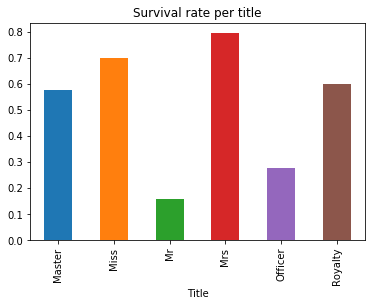

In [16]:
train_data.groupby(['Title'])['Survived'].mean().plot.bar(title='Survival rate per title')

We can see that there is a clear correlation between the Title and the survival chances.

We can also see that the big majority of passengers with Title Mr die: we can say intuitively that men has less survival chances than women.

We will try to check this hypothesis later=> All we can say is that this feature seems to be interesting.

## Sex

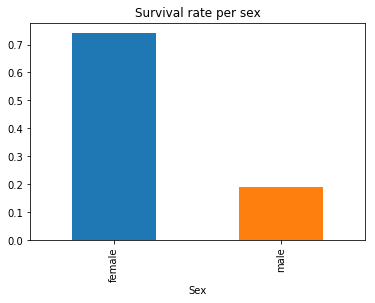

In [17]:
train_data.groupby(['Sex'])['Survived'].mean().plot.bar(title='Survival rate per sex')

<div class="alert alert-info">
We can confirm now that women has much more survival rate than men.

The sex feature is so interesting, we will keep it.
</div>

## Age

In [18]:
train_data.groupby('Survived')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,549.0,30.028233,12.499986,1.00,23.0,28.0,35.0,74.0
1,340.0,28.163735,13.672269,0.42,21.0,28.0,35.0,80.0


Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Age, dtype: object

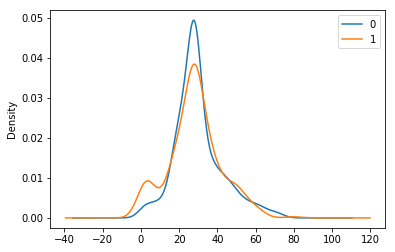

In [19]:
train_data.groupby('Survived')['Age'].plot.density(legend=True)

The age doesn't seem to have a direct effect on the  survival chances. The only clear difference can be found among kids, it appears that kids (age <= 16) have more chances to survive

As we said at the beginning, we prefer to work on categorical variables, so we will cut the age column into 5 pieces.

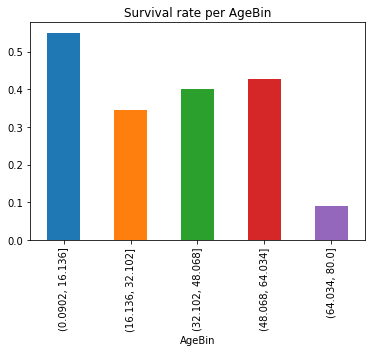

In [20]:

all_ages = train_data['Age'].append(test_data['Age'])
age_cuts = pd.cut(all_ages, 5).unique()
def get_good_age_cut(age):
    for cut in age_cuts:
        if age in cut:
            return cut
        
for data in datas:
    data['AgeBin'] = data['Age'].map(lambda x: get_good_age_cut(x))

train_data.groupby(['AgeBin'])['Survived'].mean().plot.bar(title='Survival rate per AgeBin')

There are two main remarks:
- Kids have more chances to survive
- Old passengers are more likely to die.

=> This feature is interesting, we will keep it

## SibSp and Parch


The first intuition is to build a new feature 'Family' which equal to the number of passenger's family members.

In [21]:

for data in datas:
    data['Family'] = data['SibSp'] + data['Parch'] + 1
    
train_data.groupby(['Family'])['Survived'].describe()

,count,mean,std,min,25%,50%,75%,max
Family,,,,,,,,
1,535.0,0.300935,0.459094,0.0,0.0,0.0,1.0,1.0
2,161.0,0.552795,0.498756,0.0,0.0,1.0,1.0,1.0
3,102.0,0.578431,0.496249,0.0,0.0,1.0,1.0,1.0
4,29.0,0.724138,0.454859,0.0,0.0,1.0,1.0,1.0
5,15.0,0.200000,0.414039,0.0,0.0,0.0,0.0,1.0
6,22.0,0.136364,0.351250,0.0,0.0,0.0,0.0,1.0
7,12.0,0.333333,0.492366,0.0,0.0,0.0,1.0,1.0
8,6.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
11,7.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


<div class="alert alert-info">
Single passengers and big families members are more likely to die
</div>

Let's we will categorise this feature


In [22]:
def get_family_type(members_number):
    if members_number <= 1:
        return 'Small'
    if members_number <= 4:
        return 'Medium'
    return 'Big'

for data in datas:
    data['FamilyType'] = data['Family'].map(lambda x: get_family_type(x))

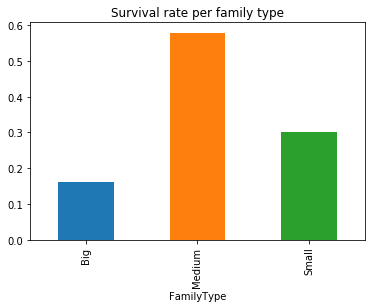

In [23]:
train_data.groupby(['FamilyType'])['Survived'].mean().plot.bar(title='Survival rate per family type')

## Fare

As discussed before, it seems that wealthy people are more likely to survive.

Survived
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Fare, dtype: object

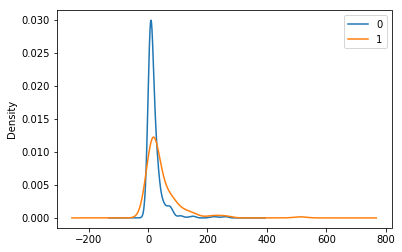

In [24]:
train_data.groupby('Survived')['Fare'].plot.density(legend=True)

Like we did for age, we will cut out Fare column into 4 pieces

In [25]:

all_fares = train_data['Fare'].append(test_data['Fare'])
fare_cuts = pd.qcut(all_fares, 4).unique()
print(fare_cuts)
def get_good_fare_cut(fare):
    for cut in fare_cuts:
        if fare in cut:
            return cut
        
for data in datas:
    data['FareBin'] = data['Fare'].map(lambda x: get_good_fare_cut(x))

train_data.groupby(['FareBin'])['Survived'].describe()

[(-0.001, 7.896], (31.275, 512.329], (7.896, 14.454], (14.454, 31.275]]
Categories (4, interval[float64]): [(-0.001, 7.896] < (7.896, 14.454] < (14.454, 31.275] < (31.275, 512.329]]


,count,mean,std,min,25%,50%,75%,max
FareBin,,,,,,,,
"(-0.001, 7.896]",223.0,0.197309,0.398863,0.0,0.0,0.0,0.0,1.0
"(7.896, 14.454]",217.0,0.308756,0.463048,0.0,0.0,0.0,1.0,1.0
"(14.454, 31.275]",236.0,0.432203,0.496435,0.0,0.0,0.0,1.0,1.0
"(31.275, 512.329]",210.0,0.590476,0.492921,0.0,0.0,1.0,1.0,1.0


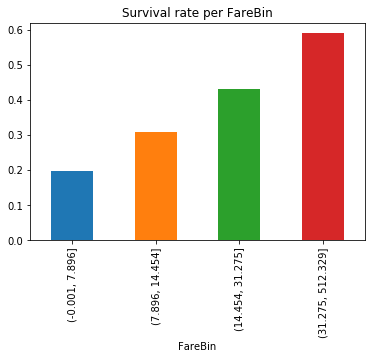

In [26]:
train_data.groupby(['FareBin'])['Survived'].mean().plot.bar(title='Survival rate per FareBin')

<div class="alert alert-info">
There is a clear correlation between paid fares anb survival rate
</div>

## Cabin

In [27]:
train_data['Cabin'].unique()

array(['NoCabin', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'C83', 'F33', 'F G73',
       'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'F E69',
       'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4', 'A32',
       'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35', 'C87', 'B77',
       'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19', 'B49', 'D',
       'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44', 'A34', 'C104', 'C111',
       'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30', 'D20',
       'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22', 'C86',
       'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19',
       'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126', 'B71',
       'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63', 'C62 C64', 'E24', 

There are two main information that we can extract from this feature:
    - The cabin type (A, B, C, D, E, F)
    - Whether a passenger has a cabin or not (assuming that missing values correspond to people without cabin)
=> Let's add those two features

In [28]:
def get_cabin_type(cabin_name):
    if cabin_name == 'NoCabin':
        return 'NoType'
    cabins_types = ['A', 'B', 'C', 'D', 'E', 'F']
    for cabin_type in cabins_types:
        if cabin_type in cabin_name:
            return cabin_type
    return 'NoType'

for data in datas:
    data['CabinType'] = data['Cabin'].map(lambda x: get_cabin_type(x))


In [29]:
train_data.groupby('CabinType')['Survived'].describe()

,count,mean,std,min,25%,50%,75%,max
CabinType,,,,,,,,
A,15.0,0.466667,0.516398,0.0,0.0,0.0,1.0,1.0
B,45.0,0.733333,0.447214,0.0,0.0,1.0,1.0,1.0
C,59.0,0.593220,0.495450,0.0,0.0,1.0,1.0,1.0
D,33.0,0.757576,0.435194,0.0,1.0,1.0,1.0,1.0
E,33.0,0.757576,0.435194,0.0,1.0,1.0,1.0,1.0
F,12.0,0.583333,0.514929,0.0,0.0,1.0,1.0,1.0
NoType,692.0,0.300578,0.458841,0.0,0.0,0.0,1.0,1.0


The big majority of people has no cabin. The number of rows per cabin type is so small => It doesn't worth to keep this feature

In [30]:
train_data.drop('CabinType', axis=1, inplace=True)
test_data.drop('CabinType', axis=1, inplace=True)

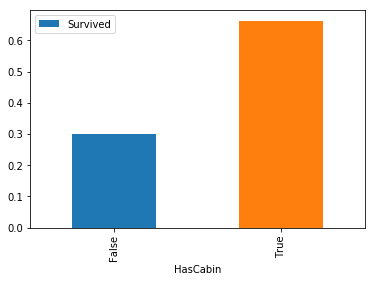

In [31]:
for data in datas:
    data['HasCabin'] = data['Cabin'].map(lambda x: x != 'NoCabin')
    
train_data.groupby(['HasCabin'])['Survived'].mean().plot.bar(legend=True)

Passengers without Cabin are more likely to die.

This feature is interesting, so we will keep it.

### Ticket

Let's see if we can extract something from this column

In [32]:
train_data['Ticket'].head(10)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
8              347742
9              237736
Name: Ticket, dtype: object

 We see that there are two types of tickets: 
    - alpha numeric tickets
    - numeric tickets
 We do not know the difference between both types, but may be we will discover something

In [33]:
for data in datas:
    data['TicketType'] = data['Ticket'].apply(lambda x: 'Numeric' if len(x.split(' ')) == 1 else 'AplhaNumeric')

In [34]:
train_data.groupby('TicketType')['Survived'].describe()

,count,mean,std,min,25%,50%,75%,max
TicketType,,,,,,,,
AplhaNumeric,226.0,0.384956,0.487665,0.0,0.0,0.0,1.0,1.0
Numeric,663.0,0.381599,0.486146,0.0,0.0,0.0,1.0,1.0


This feature doesn't seem to have any direct effect on survival chances, but we let's keep it:
maybe, coupled with other features, our ml will detect some pattern.

## Embarked

S    644
C    168
Q     77
Name: Embarked, dtype: int64


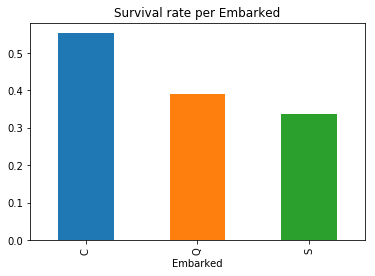

In [35]:
print(train_data['Embarked'].value_counts())
train_data.groupby('Embarked')['Survived'].mean().plot.bar(title='Survival rate per Embarked')

There is a strong correlation between survival rate and this feature, so let's keep in mind 
that it will be probably usefull for us.

## Features selection

Let's refresh our memory: Those are our columns until now. We will keep only categorical ones

In [36]:
list(train_data.columns)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked',
 'Title',
 'AgeBin',
 'Family',
 'FamilyType',
 'FareBin',
 'HasCabin',
 'TicketType']

In [37]:
# the first thing to do now is to capture all possible input columns and put the output in a separed variables
input_columns = ['Pclass', 'Sex', 'Embarked', 'Title', 'AgeBin', 'FamilyType',
                'FareBin', 'HasCabin', 'TicketType']

X_train, X_test = train_data[input_columns], test_data[input_columns]
y_train = train_data['Survived']

Now we will one-hot encode, but before that, to make things easy (we want later to play with columns)
we will make sure that our categorical data has a string type

In [38]:
for column in input_columns:
    X_train[column] = X_train[column].astype('str')
    X_test[column] = X_test[column].astype('str')


/Users/yassineameur/.virtualenvs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/yassineameur/.virtualenvs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Let's make sure that our data types are all string

In [39]:
X_train.dtypes

Pclass        object
Sex           object
Embarked      object
Title         object
AgeBin        object
FamilyType    object
FareBin       object
HasCabin      object
TicketType    object
dtype: object

### One Hot Encoding

To encode easily our data, we will use a library called '<B> one_hot_encoder </B>': I made it for you:  it makes one hot encoding very easy and clear when working with pandas

In [40]:
"""
# This code is commented because the library one_hot_encoder is not installed on kaggle kernek
from one_hot_encoder.encoder import Encoder

oh_encoder = Encoder(drop_first=True)
oh_encoder.fit(X_train)
X_train = oh_encoder.get_dummies(X_train)
X_test = oh_encoder.get_dummies(X_test)
"""
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [41]:
X_train.columns

Index(['Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty',
       'AgeBin_(16.136, 32.102]', 'AgeBin_(32.102, 48.068]',
       'AgeBin_(48.068, 64.034]', 'AgeBin_(64.034, 80.0]', 'FamilyType_Medium',
       'FamilyType_Small', 'FareBin_(14.454, 31.275]',
       'FareBin_(31.275, 512.329]', 'FareBin_(7.896, 14.454]', 'FareBin_None',
       'HasCabin_True', 'TicketType_Numeric'],
      dtype='object')

### Most important features

Before going to classification algorithms, it would be cool to disciver which features are very important when we apply for example a random forest algorithm

In [42]:
from sklearn.ensemble import RandomForestClassifier

def find_most_important_features(X, y):
    """
    :param X: data
    :param y: labels
    :return: returns the list of columns ordered by their importance and the list of their scores
    """

    forest = RandomForestClassifier(n_estimators=250)
    forest.fit(X, y)
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    columns = list(X.columns)

    columns_by_importance = []
    importance_by_column = []
    for f in range(X.shape[1]):
        columns_by_importance.append(columns[indices[f]])
        importance_by_column.append(importances[indices[f]])
    
    
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(15,5))
    plt.xticks(np.arange(len(columns_by_importance)), columns_by_importance, rotation=90)
    plt.bar(np.arange(len(columns_by_importance)), importance_by_column)


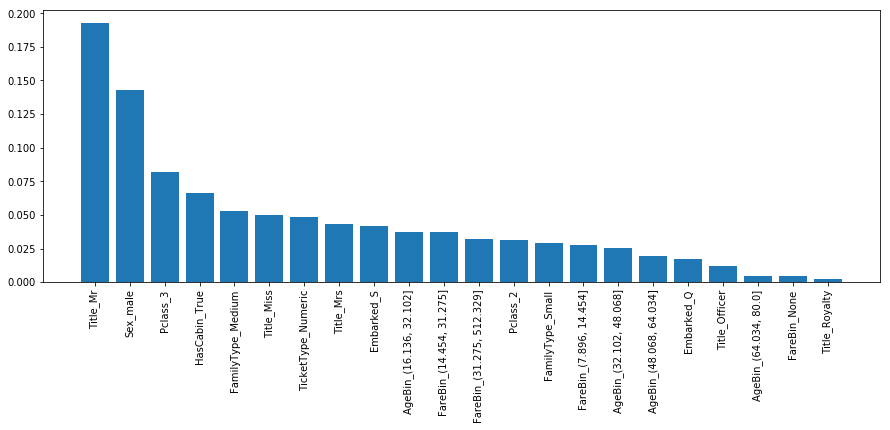

In [43]:
find_most_important_features(X_train, y_train)

### Select KBest
In this section, we will use the select KBest algorithm, we will retain the best 15 features.

We will put this list of features into the variable 'k_best_columns'

In [44]:
# Here we will use the select kbest features algo
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)

k_best_algo = SelectKBest(chi2, 10)
k_best_algo.fit(X_train, y_train)
k_best_features = X_train.columns.values[k_best_algo.get_support()]
print(k_best_features)

['Pclass_2' 'Pclass_3' 'Sex_male' 'Title_Miss' 'Title_Mr' 'Title_Mrs'
 'FamilyType_Medium' 'FamilyType_Small' 'FareBin_(31.275, 512.329]'
 'HasCabin_True']


### Recursive feature elimination
In this section, we will use the recursive features elimination algorithm. We will put the results of this algorihm into the variable 'rfe_columns'

In [57]:
# here we will use the recursive features elimination alvorithm
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

len_rfe_features = float('inf')
while len_rfe_features > 7:
    rfe = RFECV(RandomForestClassifier(), step=1, cv=kfold, n_jobs=2)
    rfe.fit(X_train, y_train)
    rfe_features = X_train.columns.values[rfe.get_support()]
    len_rfe_features = len(rfe_features)
print(rfe_features)


['Pclass_3' 'Sex_male' 'Embarked_S' 'Title_Mr' 'FamilyType_Medium'
 'FareBin_(31.275, 512.329]' 'HasCabin_True']


<div class="alert alert-info">
We have 3 types of inout features:
   <ul>
    <li> All features (more than 15 features)</li>
    
    <li> Kbest features (10 features)</li>
     
    <li> rfe_features (7 features)</li>
    </ul>
   
</div>

### Model selection

In this section, we will use classification algorithms with all features types. And each time, we will register the train and test score.

In [58]:
# We will try here many machine learning algorithms to fetch those who has the best performance
def get_classififcation_algorithms():
    """returns a list of ml algorithms"""
    from sklearn import ensemble, linear_model, neighbors, svm, tree
        
    return [
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(n_estimators = 100),
    neighbors.KNeighborsClassifier(n_neighbors = 3),
    svm.SVC(probability=True),
    svm.LinearSVC(),
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier()]


In [59]:
from sklearn.model_selection import cross_validate

def get_classification_results(alg, X, y, cv):
    results = cross_validate(alg, X, y, cv=cv, return_train_score=True)
    
    return {
        'alg_name': alg.__class__.__name__,
        'train_score': results['train_score'].mean(),
        'test_score': results['test_score'].mean()
    }
    

In [60]:
ml_results = []

columns_types = [
    ('rfe', rfe_features),
    ('k_best', k_best_features),
    ('all_features', list(X_test.columns))]

for columns_type, columns in columns_types:
    for alg in get_classififcation_algorithms():
        classification_results = get_classification_results(alg, X_train[columns], y_train, kfold)
        classification_results['columns_type'] = columns_type
        ml_results.append(classification_results)

results_df = pd.DataFrame(list(ml_results))
# We build a column which represents the diff between the train and tests score
results_df['train_test_diff%'] = 100*(results_df['train_score'] - results_df['test_score'])/results_df['train_score']


In [61]:
results_df.sort_values(by='test_score', ascending=False).head(n=10)

,alg_name,columns_type,test_score,train_score,train_test_diff%
27,LinearSVC,all_features,0.826782,0.834086,0.875612
20,AdaBoostClassifier,all_features,0.824484,0.831830,0.883141
16,SVC,k_best,0.821126,0.823961,0.344000
24,RandomForestClassifier,all_features,0.820022,0.900170,8.903686
11,BaggingClassifier,k_best,0.820022,0.838301,2.180487
1,BaggingClassifier,rfe,0.820009,0.839425,2.313072
14,RandomForestClassifier,k_best,0.817768,0.839988,2.645224
3,GradientBoostingClassifier,rfe,0.816657,0.839146,2.679933
18,DecisionTreeClassifier,k_best,0.816657,0.839708,2.745090
13,GradientBoostingClassifier,k_best,0.816619,0.836333,2.357159


In [62]:
results_df.groupby(['columns_type'])['train_test_diff%'].mean()

columns_type
all_features    6.853294
k_best          2.132368
rfe             2.459235
Name: train_test_diff%, dtype: float64

In [63]:
results_df.groupby(['columns_type'])['test_score'].mean()

columns_type
all_features    0.811135
k_best          0.812818
rfe             0.809113
Name: test_score, dtype: float64

<div class="alert  alert-info">
We see that that kbest features gives the best test score.  <b> But how can that happen ? </b> That's simple, it is true that you have less features than all_features but all those few features have a big impact on classification result. They made your classification algorithms smarter and robust to adapt itself to situations not seen before. So you avoided overfitting. Besides, it is better than rfe because it is smarter and have more features. So, it is all about the sufficient number of features that you should use duting the learning phase. A lot of featutres => overfitting. Little number of features => undefitting
</div>

### The voting estimator

Until now, we have tried many classification algorithms. This time, we will try a voting system: It will use all algorithms decisions to make just one decision.

In [64]:

from sklearn.ensemble import VotingClassifier
voting_estimators = [
 (est.__class__.__name__ , est)   for est in get_classififcation_algorithms()
]
from sklearn import ensemble
voting_hard = ensemble.VotingClassifier(estimators = voting_estimators , voting = 'hard')
voting_hard_cv = get_classification_results(voting_hard, X_train[rfe_features], y_train, kfold)
print('train score = ', voting_hard_cv['train_score'].mean())
print('test score = ', voting_hard_cv['test_score'].mean())


train score =  0.840833846932
test score =  0.81554624516


<div class="alert  alert-info">
The voting system doesn't seem to have an added value
</div>

### Grid Search

In this section, we will try to find the random forest classifier's best parameters that gives us the best test score.
Until now, for the algorithms that we used, we did not tune hyper parameters that give the optimal performance: That's the aim of this section. We will used GridSearch on random forest classifier to find optimal parameters

In [65]:

from sklearn.model_selection import GridSearchCV

rf_grid = {
        'n_estimators': [100, 200, 500],
        'max_depth': [5, 10, 20],
        'max_leaf_nodes': [None, 10, 100],
        'min_samples_split': [5, 10, 50]
}
used_columns = rfe_features

rf_alg = RandomForestClassifier()
grid_search = GridSearchCV(
        estimator=rf_alg, param_grid=rf_grid,
        n_jobs=1, cv=3, refit=True, verbose=1)
grid_search.fit(X_train[used_columns], y_train)

best_estimator = grid_search.best_estimator_
print('Random forest\'s best test score = {}'.format(grid_search.best_score_))

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Done 243 out of 243 | elapsed:  1.4min finished


Random forest's best test score = 0.8357705286839145


# The confusion matrix

In this section, we will plot the confusion matrix to have closer idea about random forest performance

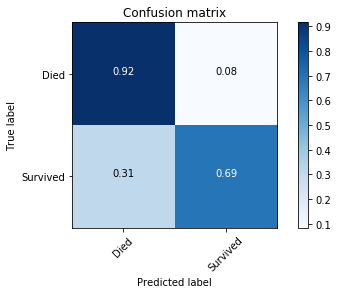

In [66]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

cv_predictions = cross_val_predict(
    best_estimator, 
    X_train[used_columns], 
    y_train, cv=kfold)

plot_confusion_matrix(confusion_matrix(y_train, cv_predictions), ['Died', 'Survived'], normalize=True)

### Predicitions:

Finally we use the function predict to predict whether a passenger survived or not. 

In [68]:
test_predictions = best_estimator.predict(X_test[used_columns])

test_data['Survived'] = test_predictions
test_data[['PassengerId', 'Survived']].to_csv('predictions.csv', index=False)
